In [11]:
from gurobipy import Model, GRB, GurobiError
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

In [12]:
np.random.seed(1)
N = 41
V = range(N)
T=200

xs = np.random.uniform(low=0, high=100, size=N)
ys = np.random.uniform(low=0, high=100, size=N)
profit = np.random.uniform(low=100,high =100,size = N)
profit[0] = 0

cost = {
    (i, j): sqrt((xs[i] - xs[j]) ** 2 + (ys[i] - ys[j]) ** 2)
    for i in V for j in V if i != j
}

A = list(cost.keys())

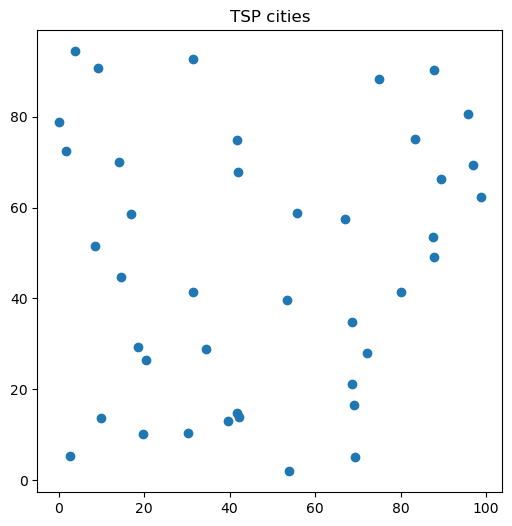

In [13]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(xs, ys)
ax.set_title('TSP cities');

In [14]:
m = Model()
x = m.addVars(A, vtype=GRB.BINARY, name='x')
y = m.addVars(V, vtype=GRB.BINARY, name='y')
m.addConstr(y[0] == 1, name='Include_First')
m.addConstrs((x.sum(i, '*') == y[i] for i in V), name='out_degree')
m.addConstrs((x.sum('*', i) == y[i] for i in V), name = 'in_degree');
m.addConstr(sum(x[i, j] * cost[i, j] for i, j in A) <= T, name='CostConstraint')
m.setObjective(sum(y[i] * profit[i] for i in V), GRB.MAXIMIZE)
m.setParam(GRB.Param.LazyConstraints, 1)

Set parameter LazyConstraints to value 1


As we are creating a SEC for our subtour, the constraints will always be greater than 1 as the include selected vertices where all ys are equal to 1.

In [15]:
def add_sec_for(subtour):
    print('Added a violated SEC')
    for k in subtour:
        m.cbLazy(sum(x[i, j] for i in subtour for j in set(V) - set(subtour)) >= y[k])
    

In [16]:
def next_after(i):
    for j in V:
        if j == i:
            continue
        try:
            if m.cbGetSolution(x[i, j]) > 0.9:
                return j
        except GurobiError:
            if x[i, j].X > 0.9:
                return j
    
    assert False, f"Vertex {i} has no successor"

In [17]:
def subtour_starting_at(vertex):
    tour = [vertex]
    current = next_after(vertex)

    while current != vertex:
        tour.append(current)
        current = next_after(current)

    return tour

In [18]:
def selectedVertices():
    selected = []

    for i in V:
        try:
            if m.cbGetSolution(y[i]) > 0.9:
                selected.append(i)
        except GurobiError:
            if y[i].X > 0.9:
                selected.append(i)
                
    return selected

In [19]:
def callback(what, where):
    if where != GRB.Callback.MIPSOL:
        return

    remaining = set(selectedVertices())
    n_remaining_vertexes = len(remaining)

    first_subtour = subtour_starting_at(vertex=0)

    if len(first_subtour) == n_remaining_vertexes:
        return
    
    remaining -= set(first_subtour)

    while len(remaining) > 0:
        current = next(iter(remaining))

        subtour = subtour_starting_at(vertex=current)

        add_sec_for(subtour)
        
        remaining -= set(subtour)

In [20]:
m.optimize(callback)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 84 rows, 1681 columns and 5003 nonzeros
Model fingerprint: 0xdfca83eb
Variable types: 0 continuous, 1681 integer (1681 binary)
Coefficient statistics:
  Matrix range     [8e-01, 1e+02]
  Objective range  [1e+02, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 200.0000000
Presolve removed 1 rows and 1 columns
Presolve time: 0.01s
Presolved: 83 rows, 1680 columns, 4998 nonzeros
Variable types: 0 continuous, 1680 integer (1680 binary)

Root relaxation: objective 2.751479e+03, 124 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2751.47901    0    4  200.00000 2751.47901  1276%     -    0s

In [21]:
remaining = set(selectedVertices())

total_profit = 0
for vert in remaining:
    total_profit += profit[vert]

first = next(iter(remaining))
all_tours = []
while len(remaining) > 0:
    subtour = subtour_starting_at(vertex=first)
    all_tours.append(subtour)
    remaining -= set(subtour)
    
print(f'Number of subtours: {len(all_tours)}')

tour = all_tours[0]

Number of subtours: 1


In [22]:
print('number of selected vertecies:', len(tour))

number of selected vertecies: 16


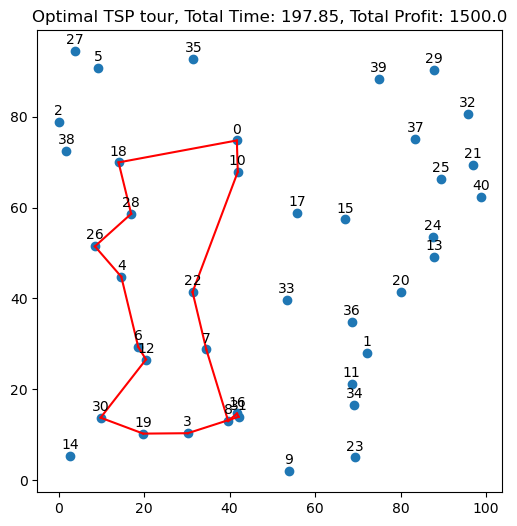

In [23]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(xs, ys)
tour2 = tour[1:] + [0]

tour_path = []

tour_cost = 0
for i, j in zip(tour, tour2):
    ax.plot((xs[i], xs[j]), (ys[i], ys[j]), color='red')
    tour_cost += cost[i, j]

for i, (x_, y_) in enumerate(zip(xs, ys)):
    ax.annotate(str(i), (x_, y_), textcoords="offset points", xytext=(0, 5), ha='center')

ax.set_title(f'Optimal TSP tour, Total Time: {round(tour_cost, 2)}, Total Profit: {round(total_profit, 2)}');